In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import numpy as np
import os

In [2]:
torch.cuda.is_available()

True

In [3]:
# Data Augmentation
# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = r"D:\Study\OnlineCourses\Complete NeuralNet BootCamp\hymenoptera_data"
#Create a dictionary that contains the information of the images in both the training and validation set
# datasets.ImageFolder takes 2 arguments --- foldername, transformation of the data
# Folder names are picked as the label name by ImageFolder API
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'val']}
#Create a dictionary that contians the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'val']}

#Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#Get the class names
class_names = image_datasets['train'].classes
# Print the results
print('Classes Names: {}'.format(class_names))
print('There are {} batches in the training set'.format(len(dataloaders['train'])))
print('There are {} batches in the test set'.format(len(dataloaders['val'])))
print('There are {} images in the training set'.format(dataset_sizes['train']))
print('There are {} images in the test set'.format(dataset_sizes['val']))

Classes Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 images in the training set
There are 153 images in the test set


In [5]:
(image_datasets)

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: D:\Study\OnlineCourses\Complete NeuralNet BootCamp\hymenoptera_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: D:\Study\OnlineCourses\Complete NeuralNet BootCamp\hymenoptera_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [6]:
# Load the resnet
model_conv = torchvision.models.resnet18(pretrained=True)

In [7]:
# Freeze all layers in the network
for param in model_conv.parameters():
    param.requires_grad = False

In [8]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer (output layer) to have only two classes 
model_conv.fc = nn.Linear(num_ftrs, 2)

In [9]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [18]:
# Understanding what's happening
iteration = 0
correct = 0
for inputs, labels in dataloaders['train']:
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For ONE iteration:")
    print("Inputs shape {}".format(inputs.shape))
    print("labels shape {}".format(labels.shape))
    print("labels {}".format(labels))
    output = model_conv(inputs)
    print("Output tensor: {}".format(output))
    print("Output shape: {}".format(output.shape))
    _, predicted = torch.max(output, 1)
    print("Predicted: ", predicted)
    print("Predicted shape: ", predicted.shape)
    correct += (predicted == labels).sum()
    print("Correct Prediction: ", correct)
    break

For ONE iteration:
Inputs shape torch.Size([4, 3, 224, 224])
labels shape torch.Size([4])
labels are tensor([0, 1, 0, 0], device='cuda:0')
Output tensor: tensor([[-0.5536, -0.6796],
        [-0.2234, -1.0769],
        [-0.8348,  0.1417],
        [ 0.0496, -0.7110]], device='cuda:0', grad_fn=<AddmmBackward>)
Output shape: torch.Size([4, 2])
Predicted:  tensor([0, 0, 1, 0], device='cuda:0')
Predicted shape:  torch.Size([4])
Correct Prediction:  tensor(2, device='cuda:0')


In [29]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)
#Try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

In [30]:
# #This is to demonstrate what happens in the background of scheduler.step()
# #No need to run this cell unless you want to create your own scheduler 
# def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
#     """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
#     lr = init_lr * (0.1**(epoch // lr_decay_epoch))

#     if epoch % lr_decay_epoch == 0:
#         print('LR is set to {}'.format(lr))
        
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

#     return optimizer

In [31]:
num_epochs = 25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    #Reset the correct to 0 after passing through all the dataset
    correct = 0
    for images, labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        # PyTorch accumulates the gradients on subsequent backward passes
        # So we need to zero out the gradient
        optimizer.zero_grad()
        output = model_conv(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Weight update
        optimizer.step()
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum()
    
    train_acc = 100 * correct / dataset_sizes['train']
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f}%'
            .format(epoch+1, num_epochs, loss.item(), train_acc))

Epoch [1/25], Loss: 0.0034, Train Accuracy: 87.7049%
Epoch [2/25], Loss: 0.4372, Train Accuracy: 85.2459%
Epoch [3/25], Loss: 0.0220, Train Accuracy: 83.6066%
Epoch [4/25], Loss: 0.0182, Train Accuracy: 84.8361%
Epoch [5/25], Loss: 1.8431, Train Accuracy: 83.1967%
Epoch [6/25], Loss: 0.0854, Train Accuracy: 84.8361%
Epoch [7/25], Loss: 0.5430, Train Accuracy: 81.5574%
Epoch [8/25], Loss: 0.3926, Train Accuracy: 79.0984%
Epoch [9/25], Loss: 0.1159, Train Accuracy: 84.4262%
Epoch [10/25], Loss: 0.1030, Train Accuracy: 81.1475%
Epoch [11/25], Loss: 0.0608, Train Accuracy: 88.1147%
Epoch [12/25], Loss: 0.0811, Train Accuracy: 86.8852%
Epoch [13/25], Loss: 1.1797, Train Accuracy: 89.7541%
Epoch [14/25], Loss: 0.2058, Train Accuracy: 90.1639%
Epoch [15/25], Loss: 0.0531, Train Accuracy: 86.4754%
Epoch [16/25], Loss: 0.0871, Train Accuracy: 85.2459%
Epoch [17/25], Loss: 0.0103, Train Accuracy: 83.1967%
Epoch [18/25], Loss: 0.1078, Train Accuracy: 91.8033%
Epoch [19/25], Loss: 0.1796, Train Ac

In [33]:
labels.size(0)

4

In [34]:
# Test the model
model_conv.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 94.771 %


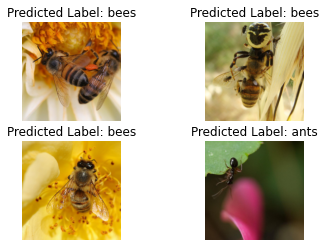

In [43]:
# Visualize the results
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for images, labels in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        #The output is of shape (4,2)
        outputs = model_conv(images)
        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        _, pred = torch.max(outputs, 1)
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2, 2, index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[pred[i]]))
            #Get the tensor of the image, and put it to cpu
            input_img = images.cpu().data[i]
            #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            inp = input_img.numpy().transpose((1,2,0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)
        # Applying break so that we will print the result for only 1 batch 
        break